In [1]:
import matplotlib.pyplot as plt
import numpy as np

from checking_tools import checkLabels, checkNormals
from Trefft_tools import TrefftzSpace, TrefftzFunction,  AssembleRHS, AssembleMatrix
from geometry_tools import Edge
from meshes import testMesh, toyMesh, waveguideMesh
from meshes import ScattererType

In [2]:
R = 10.
H = 1.
rad = 0.2

c = (0,0.)

quad = False
Omega = waveguideMesh(h_max=2*H/3,rad = rad, c=c,  scatterer_type=ScattererType.SOUND_SOFT)
#Omega = waveguideMesh(R = R, H = H, c=c, rad = rad,  scatterer_type=ScattererType.SOUND_SOFT,  quad=quad)


# Omega = testMesh( h_max= 2*H/3, quad=quad)
# #Omega = toyMesh(quad=quad)

In [3]:
Edges = [ Edge(Omega, e)  for e in Omega.edges ]

Checking the orientation of the labels...

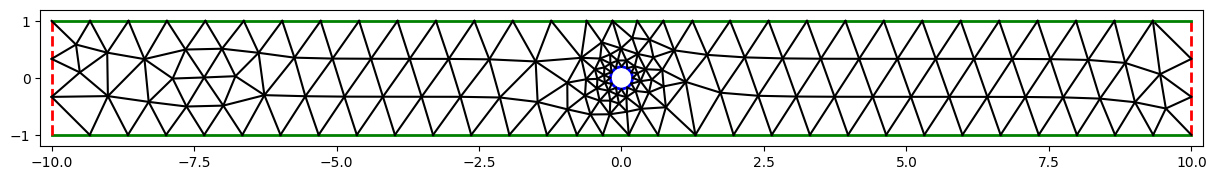

In [4]:
checkLabels(Edges)

and the orientation of the normals...

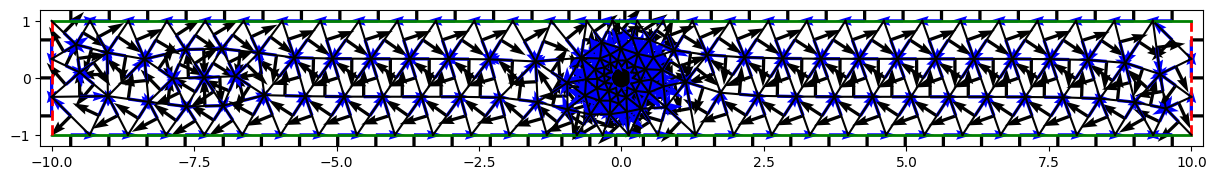

In [5]:
checkNormals(Edges)

and the definition of the "plus" and "minus" quantities...

In [6]:
  # checkPlusMinus(Edges, Baricenters) 

In [7]:
kappa_e = 8.
kappa_i = 5.


In [8]:
# #optimal angle for mode "t" : th = arcsin( lambda /  (2H)) 
# t = 2
# dth = np.arcsin( t*np.pi / (kappa_e*H))
# # optimal number of waves for mode "t":
# Nth = int(2*np.pi / dth)
# Nth 

In [9]:
Nth = 20
th = np.e/10
th = 0.
V = TrefftzSpace(Omega, Nth, {"Omega_i" : kappa_i , "Omega_e" : kappa_e}, th )


In [10]:
sparse = True

In [11]:
NP = 20
d_2 = 0.5
A = AssembleMatrix(V, Edges, Np=NP, d_2=d_2)
NDOF = A.shape[0]


In [12]:
print(f'{NDOF=}, {np.count_nonzero(A.toarray())/NDOF**2=}')

NDOF=5560, np.count_nonzero(A.toarray())/NDOF**2=0.013508617566378552


In [13]:
# Ncond = np.linalg.cond(A.toarray())
Ncond = -1
Ncond 

-1

In [14]:
# conds_00 = []
# conds_05 = []
# for Nth in range(1,12):
#     th = np.pi/np.e
#     V = TrefftzSpace(Omega, Nth, {"Omega_i" : kappa_i , "Omega_e" : kappa_e}, th )
#     NP = 20
#     A = AssembleMatrix(V, Edges, Np=NP, d_2=0., fullsides=fullsides, sparse=True)
#     conds_00.append(np.linalg.cond(A.toarray()))
#     A = AssembleMatrix(V, Edges, Np=NP, d_2=0.5, fullsides=fullsides, sparse=True)
#     conds_05.append(np.linalg.cond(A.toarray()))

# plt.plot(range(1,12),conds_00, label='d=00')
# plt.plot(range(1,12),conds_05, label='d=0.5')
# plt.legend()

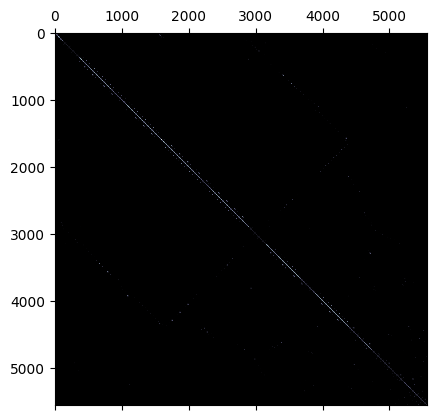

In [15]:
if sparse:
    plt.matshow(np.abs(A.toarray()), cmap='bone')
else:
    plt.matshow(np.abs(A), cmap='bone')
# for y_ in range(0,NDOF,Nth):
#     plt.hlines(y=y_,xmin=0,xmax=NDOF,colors='r')
#     plt.vlines(x=y_,ymin=0,ymax=NDOF,colors='r')


In [16]:
t = 2
B = AssembleRHS(V, Edges, kappa_e, H, d_2=d_2, t=t)

In [17]:
# d_2 = 0.5
# A_full = AssembleMatrix(V, Edges, Np=NP, d_2=d_2, fullsides=True, sparse=sparse)

# A_broken = AssembleMatrix(V, Edges, Np=NP, d_2=d_2, fullsides=False, sparse=sparse)
# plt.plot(np.abs(A_full - A_broken).toarray().ravel()[:1000])

In [18]:
#DOFs = np.linalg.solve(A,B)
from scipy.sparse.linalg import bicgstab 
from scipy.sparse.linalg import spsolve 
A = A.tocsc()
# DOFs, _ = bicgstab(A,B)
DOFs = spsolve(A,B)
f = TrefftzFunction(V,DOFs)

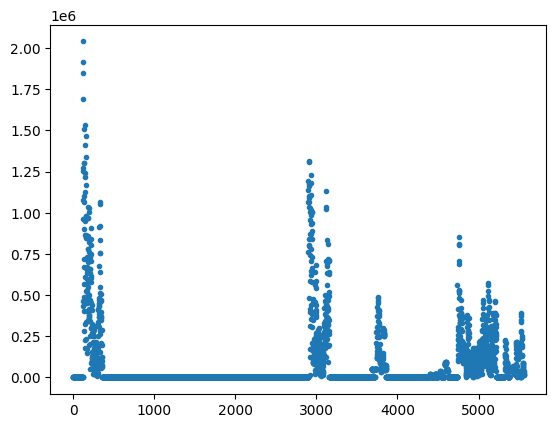

In [19]:
plt.plot(np.abs(DOFs),'.')

In [20]:
Ny = 50
Nx = 10*Ny
x = np.linspace(-R,R,Nx)
y = np.linspace(-H,H,Ny)
X, Y = np.meshgrid(x,y)

# Z = np.reshape(f(X.ravel(), Y.ravel()), [Ny,Nx]) FIX THIS, EVALUATION SHOULD BE VECTORIZED

Z =  np.reshape([ f(x_, y_) for x_, y_ in zip( X.ravel(), Y.ravel()) ], [Ny,Nx])


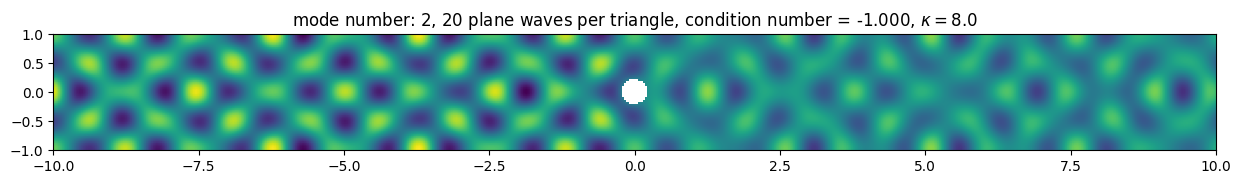

In [21]:
_, ax = plt.subplots( figsize=(15,3))

ax.imshow(np.real(Z), origin="lower", extent=[-R,R,-H,H])
#v = 1
#ax.imshow(np.real(Z), origin="lower", extent=[-R,R,-H,H], vmin=-v, vmax=v)

#checkLabels(Edges, ax)
ax.axis('square')
ax.set_xlim([-R,R])
ax.set_ylim([-H,H])
plt.title(f'mode number: {t}, {Nth} plane waves per triangle, condition number = {Ncond: .3f}, $\\kappa={kappa_e:.1f}$')

save = False
if save:
    plt.savefig(f'test_{t}_{Nth}_d2.png')

In [22]:
from FEM_solution import u_FEM_SOUNDSOFT
u_FEM = u_FEM_SOUNDSOFT(R=R, H=H, rad=rad, c = c, n=t,k=kappa_e, X=X, Y=Y)


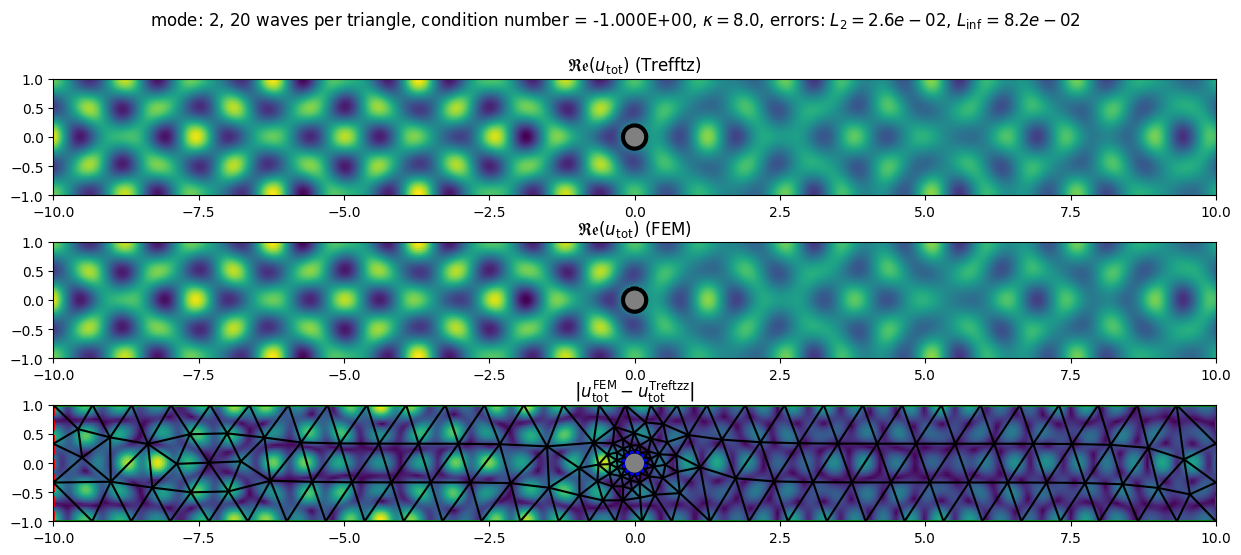

In [30]:
from matplotlib.patches import Circle
fig, ax = plt.subplots( nrows = 3, figsize=(15,6))

kwargs = {"facecolor" : "grey", "edgecolor" : "black", "linewidth" : 3}

ax[0].imshow(np.real(Z), origin="lower", extent=[-R,R,-H,H])
ax[0].add_patch(Circle(xy=c,radius=rad, **kwargs))
#checkLabels(Edges, ax[0])
ax[0].axis('square')
ax[0].set_xlim([-R,R])
ax[0].set_ylim([-H,H])

diff = np.where( (X-c[0])**2 + (Y-c[1])**2> rad**2, np.abs(Z - u_FEM), 0.)

L2_err = np.sqrt(np.mean(diff**2))
L_inf_err = np.max(diff)


ax[1].imshow(np.real(u_FEM), origin="lower", extent=[-R,R,-H,H])
ax[1].add_patch(Circle(xy=c,radius=rad, **kwargs))

# checkLabels(Edges, ax[1])
ax[1].axis('square')
ax[1].set_xlim([-R,R])
ax[1].set_ylim([-H,H])



ax[2].imshow(np.abs(Z-u_FEM), origin="lower", extent=[-R,R,-H,H])

checkLabels(Edges, ax[2])
ax[2].add_patch(Circle(xy=c,radius=rad, **kwargs))

ax[2].axis('square')
ax[2].set_xlim([-R,R])
ax[2].set_ylim([-H,H])

fig.suptitle(f'mode: {t}, {Nth} waves per triangle, condition number = {Ncond: .3E}, $\\kappa={kappa_e:.1f}$, errors: $L_2={L2_err:.1e}$, $L_\\inf={L_inf_err:.1e}$')
ax[0].set_title('$\\mathfrak{Re}\\left(u_\\mathrm{tot}\\right)$ (Trefftz)')
ax[1].set_title('$\\mathfrak{Re}\\left(u_\\mathrm{tot}\\right)$ (FEM)')
ax[2].set_title('$\\left\\vert u^\\mathrm{FEM}_\\mathrm{tot}-u^\\mathrm{Treftzz}_\\mathrm{tot}\\right\\vert$')

save = False
if save:
    plt.savefig(f'mode_{t}_{Nth}_no_d2_no_wave_in_basis.png')

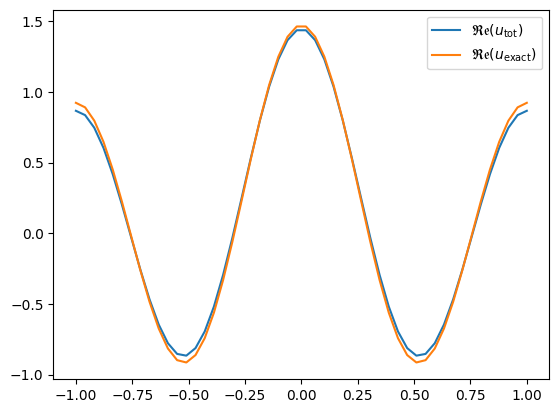

In [25]:
plt.plot(y,np.real(Z[:,0]), label='$\\mathfrak{Re}\\left(u_\\mathrm{tot}\\right)$')
plt.plot(y,np.real(u_FEM[:,0]), label='$\\mathfrak{Re}\\left(u_\\mathrm{exact}\\right)$')

plt.legend()


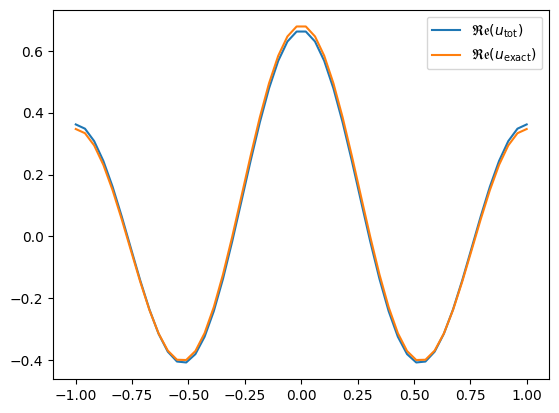

In [26]:
plt.plot(y,np.real(Z[:,-1]), label='$\\mathfrak{Re}\\left(u_\\mathrm{tot}\\right)$')
plt.plot(y,np.real(u_FEM[:,-1]), label='$\\mathfrak{Re}\\left(u_\\mathrm{exact}\\right)$')

plt.legend()


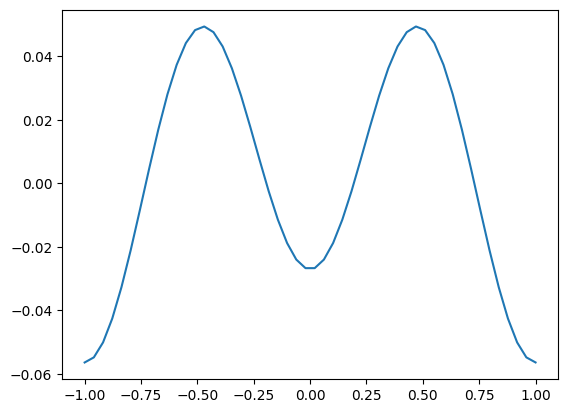

In [27]:
plt.plot(y,np.real((Z-u_FEM)[:,0]), label='$\\mathfrak{Re}\\left(u_\\mathrm{tot}\\right)$')
